In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import joblib
import json
import keras
import numpy as np
import operator
import os
import pandas as pd
from es_pandas import es_pandas
from kafka import KafkaConsumer, KafkaProducer
from kafka.structs import TopicPartition
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

In [5]:
def load_model(model_file, scaler_file):
    model = keras.models.load_model(model_file)
    scaler = joblib.load(scaler_file)
    return model, scaler

MODEL_NAME = '20210315-6m1m-conn-ssh'
MODEL_CFG = {
    'sequence_length': 12,
    'prediction_steps': 1,
    'transformation': 'diff',
    'differential': True,
    'data': {
        'in': {
            'index':['ts'],
            'columns':[
                'conn_count_uid_in',
                'ssh_count_uid_in'
            ]
        },
        'out': [
            'conn_count_uid_in',
            'ssh_count_uid_in'
        ]
    }
}
MODEL_FILE = 'mods_models/models/20210315-6m1m-conn-ssh/data_train-seq-12.h5'
SCALER_FILE = 'mods_models/models/20210315-6m1m-conn-ssh/data_train-seq-12.h5.minmaxscaler'
MODEL,SCALER = load_model(MODEL_FILE, SCALER_FILE)

In [6]:
transformations = {
    'diff': {
        'f': operator.sub,
        'f-1': operator.add
    },
    'perc': {
        'f': operator.truediv,
        'f-1': operator.mul
    },
    'log': {
        'f': lambda x,y: np.log(x)-np.log(y),
        'f-1': lambda x,y: np.exp(y)*x,
    }
}


def transform(df, k, t=transformations['diff']):
    if isinstance(df, pd.DataFrame):
        return t['f'](df[k:],df[:-k].values)
    else:
        return t['f'](df[k:],df[:-k])


def inverse_transform(pred, prev, t=transformations['diff']):
    if isinstance(df, pd.DataFrame):
        return t['f-1'](prev.values, pred)
    else:
        return t['f-1'](prev, pred)


def normalize(df, scaler, fit=False, features=None):
    fn = scaler.fit_transform if fit else scaler.transform
    if isinstance(df, pd.DataFrame):
        if features is not None:
            df[features] = fn(df[features])
            return df
        else:
            index = df.index
            columns = df.columns
            df = pd.DataFrame(fn(df), index=index)
            df = df.set_axis(columns, axis=1)
            return fn(df)
    else:
        return fn(df)


def inverse_normalize(df, scaler, features):
    fn = scaler.inverse_transform
    if isinstance(df, pd.DataFrame):
        if features is not None:
            df[features] = fn(df[features].values)
            return df
        else:
            index = df.index
            columns = df.columns
            df = pd.DataFrame(fn(df), index=index)
            df = df.set_axis(columns, axis=1)
            return fn(df)
    else:
        return fn(df.values)

In [7]:
features = MODEL_CFG['data']['in']['columns']
features_predicted = MODEL_CFG['data']['out']
context_length = MODEL_CFG['sequence_length'] + (MODEL_CFG['prediction_steps'] if MODEL_CFG['differential'] else 0)

print('features: %s' % features)
print('features_predicted: %s' % features_predicted)
print('context_length: %s' % context_length)
print('sequence_length: %s' % MODEL_CFG['sequence_length'])

features: ['conn_count_uid_in', 'ssh_count_uid_in']
features_predicted: ['conn_count_uid_in', 'ssh_count_uid_in']
context_length: 13
sequence_length: 12


In [8]:
data = pd.read_csv('buffer.tsv', sep='\t', index_col=['ts'])
data.index = pd.to_datetime(data.index, unit='ms')
split_at = '2021-03-17 17:00'
data_a = data.loc[:split_at] # in kibana 18:00
data_b = data.loc[split_at:][1:] # in kibana 18:00

In [9]:
# df = data_a[-context_length:]
df = data
display(df)
t = transformations[MODEL_CFG['transformation']]
df_x = df[1:].copy(deep=True)
df_x[:] = transform(df.to_numpy(), MODEL_CFG['prediction_steps'], t=t)
display(df_x)

,conn_count_uid_in,ssh_count_uid_in
ts,,
2021-03-04 10:50:00,9889.0,254.0
2021-03-04 12:40:00,88.0,5.0
2021-03-04 12:50:00,27036.0,1765.0
2021-03-04 13:00:00,17327.0,725.0
2021-03-04 13:10:00,12436.0,298.0
...,...,...
2021-03-17 17:40:00,26657.0,2344.0
2021-03-17 17:50:00,28884.0,2445.0
2021-03-17 18:00:00,23318.0,1787.0


,conn_count_uid_in,ssh_count_uid_in
ts,,
2021-03-04 12:40:00,-9801.0,-249.0
2021-03-04 12:50:00,26948.0,1760.0
2021-03-04 13:00:00,-9709.0,-1040.0
2021-03-04 13:10:00,-4891.0,-427.0
2021-03-04 13:20:00,8031.0,1368.0
...,...,...
2021-03-17 17:40:00,9552.0,1596.0
2021-03-17 17:50:00,2227.0,101.0
2021-03-17 18:00:00,-5566.0,-658.0


In [10]:
df_x[:] = normalize(df_x.to_numpy(), SCALER)
display(df_x)

,conn_count_uid_in,ssh_count_uid_in
ts,,
2021-03-04 12:40:00,0.479655,0.498107
2021-03-04 12:50:00,0.501910,0.515010
2021-03-04 13:00:00,0.479711,0.491452
2021-03-04 13:10:00,0.482629,0.496609
2021-03-04 13:20:00,0.490454,0.511711
...,...,...
2021-03-17 17:40:00,0.491375,0.513630
2021-03-17 17:50:00,0.486939,0.501052
2021-03-17 18:00:00,0.482220,0.494666


In [11]:
# pred = MODEL.predict(df_x.to_numpy()[np.newaxis])
# display(pred)

In [25]:
df[-1:].index + pd.tseries.offsets.Minute(n=10)

DatetimeIndex(['2021-03-17 18:30:00'], dtype='datetime64[ns]', name='ts', freq=None)

In [26]:
df[-1:].reset_index(level=0)['ts'] + pd.tseries.offsets.Minute(n=10)

0   2021-03-17 18:30:00
Name: ts, dtype: datetime64[ns]

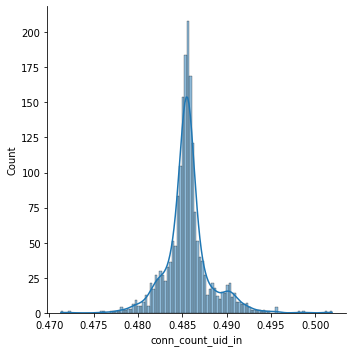

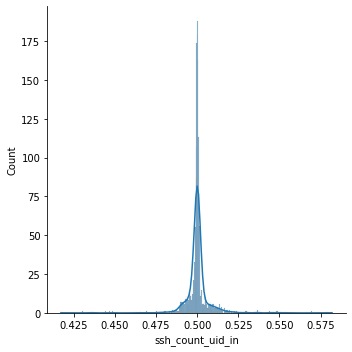

In [12]:
import seaborn as sns
sns.displot(df_x['conn_count_uid_in'], kde=True)
sns.displot(df_x['ssh_count_uid_in'], kde=True)

In [14]:
df_x

,conn_count_uid_in,ssh_count_uid_in
ts,,
2021-03-04 12:40:00,0.479655,0.498107
2021-03-04 12:50:00,0.501910,0.515010
2021-03-04 13:00:00,0.479711,0.491452
2021-03-04 13:10:00,0.482629,0.496609
2021-03-04 13:20:00,0.490454,0.511711
...,...,...
2021-03-17 17:40:00,0.491375,0.513630
2021-03-17 17:50:00,0.486939,0.501052
2021-03-17 18:00:00,0.482220,0.494666


In [15]:
df_x[-1:]

,conn_count_uid_in,ssh_count_uid_in
ts,,
2021-03-17 18:20:00,0.482741,0.495061
